In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
import pymc3 as pm
import skymotion
import skymotionModified
import skyfield
import corner
from scipy import optimize
from astropy.coordinates import SkyCoord
from tqdm import tqdm

##set random seed
rand_seed = np.random.randint(0,2**32-1)
## note jet angle is defined opposite to convention 
V404_jet_angle = 16 ## it is -16 in literature 
J1820_jet_angle = -64 ## it is 64 in literature
mc_iterations = 100
print("Random seed:", rand_seed)
%matplotlib inline

Random seed: 1257376085


In [2]:
def jet_coordinates(alpha, delta, beta):
    """
    Applying a rotation matrix to transform ra and dec into parallel and perpendicular 
    to jet axis components.
    
    Parameters
    ----------
    alpha: Observation RA, an array, in degrees.
    
    delta: Observation Dec, an array, in degrees.

    beta: rotation angle (jet angle), in degrees.
    
    Returns
    -------    
    theta_perp, theta_para: rotated coordinates, perpendicular and parallel to the jet, respectively (in degrees).
    
    """
    beta_radian = np.radians(beta)
    theta_perp = alpha * np.cos(beta_radian) + delta * np.sin(beta_radian)
    theta_para = delta * np.cos(beta_radian) - alpha * np.sin(beta_radian)
    return theta_perp, theta_para

def mc_normal_sampler(mu, sigma):
    s = np.random.normal(mu, sigma, 10000)
    output = float(np.random.choice(s,1)[0])
    return output

def mc_trace_sampler(trace):
    output  = float(np.random.choice(trace,1)[0])
    return output

def perturbObsBasedOnErr(obs_alpha, obs_alpha_err, obs_delta, obs_delta_err):
    
    output_alpha = []
    output_delta = []
    
    for i in range(len(obs_alpha)):
        output_alpha.append(mc_normal_sampler(obs_alpha[i], obs_alpha_err[i]))
        output_delta.append(mc_normal_sampler(obs_delta[i], obs_delta_err[i]))
        
    return np.array(output_alpha), np.array(output_delta)

### Load data

In [3]:
V404_Xband = Table.read('./V404Cygni_XBand_positions.txt', format='ascii',names=['RA', 'RA_err', 'DEC', 'DEC_err', 'MJD', 'MJD_err', "label"])
V404_Cband = Table.read("./V404Cygni_CBand_globalfitV3.txt", format='ascii',names=['MJD', 'MJD_err', 'RA', 'RA_err', 'DEC', 'DEC_err', 'label'])

J1820_band = Table.read("./MAXIJ1820_positions_global_model.txt", format="ascii",names=['MJD','MJD_error','RA','RAs_er','Dec','Decs_er',
                         'Telescope','Band','Calib'])
J1820_calib = Table.read('MAXIJ1820_calib_data.txt',format='ascii')

#### Correct for core-shift due to phase ref source (J1820 only)

In [4]:
J1820_band.add_column(Table.Column(data=np.full(len(J1820_band), np.nan), name='sys_ra'))
J1820_band.add_column(Table.Column(data=np.full(len(J1820_band), np.nan), name='sys_dec'))

J1820_band.add_column(Table.Column(data=np.full(len(J1820_band), np.nan), name='core_shift_ra'))
J1820_band.add_column(Table.Column(data=np.full(len(J1820_band), np.nan), name='core_shift_dec'))

J1820_band.add_column(Table.Column(data=np.full(len(J1820_band), np.nan), name='core_shift_ra_er'))
J1820_band.add_column(Table.Column(data=np.full(len(J1820_band), np.nan), name='core_shift_dec_er'))

for obs in J1820_band:
    obs_cal = J1820_calib[(J1820_calib['Calibrator'] == obs['Calib']) & (J1820_calib['Band'] == obs['Band'])]
    obs['core_shift_ra'] = obs_cal['offset_RA']
    obs['core_shift_dec'] = obs_cal['offset_dec']
    obs['core_shift_ra_er'] = obs_cal['offset_RA_er']
    obs['core_shift_dec_er'] = obs_cal['offset_dec_er']
    if obs['Telescope'] == 'VLBA':
        obs['sys_ra'] = np.sqrt(obs_cal['sys_VLBA_RA']**2 + obs_cal['Ion.sys.ra']**2)
        obs['sys_dec'] = np.sqrt(obs_cal['sys_VLBA_DEC']**2 + obs_cal['Ion.sys.dec']**2)
    elif obs['Telescope'] == 'EVN':
        obs['sys_ra'] = np.sqrt(obs_cal['sys_EVN_RA']**2 + obs_cal['Ion.sys.ra']**2)
        obs['sys_dec'] = np.sqrt(obs_cal['sys_EVN_DEC']**2 + obs_cal['Ion.sys.dec']**2)


In [5]:
J1820_band

MJD,MJD_error,RA,RAs_er,Dec,Decs_er,Telescope,Band,Calib,sys_ra,sys_dec,core_shift_ra,core_shift_dec,core_shift_ra_er,core_shift_dec_er
float64,float64,str16,float64,str15,float64,str4,int64,str5,float64,float64,float64,float64,float64,float64
58193.65126,0.0577,18:20:21.9386536,1.15e-07,07:11:07.170025,3.81e-06,VLBA,15,J1813,58.37998372730161,102.18710339372576,-0.29,-0.05,0.08,0.02
58397.01055,0.02876,18:20:21.9384875,2.65e-07,07:11:07.166302,9.82e-06,VLBA,15,J1813,58.37998372730161,102.18710339372576,-0.29,-0.05,0.08,0.02
58407.71087,0.15983,18:20:21.9384883,3.164e-06,07:11:07.166075,2.787e-05,EVN,5,J1821,76.04647000354454,124.28832447177008,0.0,0.0,0.0,0.0
58441.72508,0.22508,18:20:21.9384770,8.8e-07,07:11:07.165549,3.088e-05,VLBA,15,J1813,58.37998372730161,102.18710339372576,-0.29,-0.05,0.08,0.02
58457.0423,0.07401,18:20:21.9384371,1.5981e-05,07:11:07.164846,0.00011992,EVN,5,J1821,76.04647000354454,124.28832447177008,0.0,0.0,0.0,0.0
58474.85579,0.05799,18:20:21.9384619,1.3575e-05,07:11:07.164983,0.00040491,VLBA,5,J1821,43.466511247165904,164.47582223536685,0.0,0.0,0.0,0.0
58562.25354,0.157,18:20:21.9384324,1.233e-06,07:11:07.163533,9.09e-06,EVN,5,J1821,76.04647000354454,124.28832447177008,0.0,0.0,0.0,0.0
58718.059,0.02705,18:20:21.9382958,7.68e-07,07:11:07.160872,2.131e-05,VLBA,5,J1821,43.466511247165904,164.47582223536685,0.0,0.0,0.0,0.0
58718.14182,0.04743,18:20:21.9383011,3.42e-07,07:11:07.160709,1.355e-05,VLBA,15,J1821,36.363960180376395,111.1948564457907,0.0,0.0,0.0,0.0


#### Modify data to prefered data types

In [6]:
V404_timeX = V404_Xband['MJD'].data
V404_alphaX = SkyCoord(V404_Xband['RA'], V404_Xband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
V404_deltaX = SkyCoord(V404_Xband['RA'], V404_Xband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree
V404_alpha_errX = V404_Xband['RA_err']/3600.0*15
V404_delta_errX = V404_Xband['DEC_err']/3600.0

V404_timeC = V404_Cband['MJD'].data
V404_alphaC = SkyCoord(V404_Cband['RA'], V404_Cband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
V404_deltaC = SkyCoord(V404_Cband['RA'], V404_Cband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree
V404_alpha_errC = V404_Cband['RA_err']/3600.0*15
V404_delta_errC = V404_Cband['DEC_err']/3600.0


J1820_time = J1820_band['MJD'].data
J1820_alpha = SkyCoord(J1820_band['RA'], J1820_band['Dec'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
J1820_delta = SkyCoord(J1820_band['RA'], J1820_band['Dec'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree

## core shifts are in *arcsecs* (NOT SECONDS OF ARC)
J1820_alpha += J1820_band['core_shift_ra'] * 1e-3 / 3600
J1820_delta += J1820_band['core_shift_dec'] * 1e-3 / 3600

J1820_alpha_err = ((J1820_band['RAs_er'].data/ 3600.0 * 15 * np.cos(np.radians(J1820_delta)))**2 + 
                            (J1820_band['sys_ra'].data*1e-6/3600)**2 + 
                            (J1820_band['core_shift_ra_er'].data*1e-6/3600)**2)**0.5

J1820_delta_err = ((J1820_band['Decs_er'].data/ 3600.0)**2 + 
                            (J1820_band['sys_dec'].data*1e-6/3600)**2 + 
                            (J1820_band['core_shift_dec_er'].data*1e-6/3600)**2)**0.5



#### Combine X band and C band data (V404)

In [7]:
V404_timeXC = np.concatenate((V404_timeX, V404_timeC))
V404_alphaXC = np.concatenate((V404_alphaX, V404_alphaC))
V404_deltaXC = np.concatenate((V404_deltaX, V404_deltaC))
V404_alpha_errXC = np.concatenate((V404_alpha_errX, V404_alpha_errC))
V404_delta_errXC = np.concatenate((V404_delta_errX, V404_delta_errC))
V404_maskXC = np.concatenate((np.full((len(V404_timeX)), False), np.full((len(V404_timeC)), True)))
V404_x_labels, V404_c_labels = [], []
for label in V404_Xband['label']:
    V404_x_labels.append("x-" + str(label))
for label in V404_Cband['label']:
    V404_c_labels.append("c-" + str(label))

V404_labelXC = np.concatenate(( V404_x_labels, V404_c_labels))

#### bool mask for J1820

In [8]:
J1820_mask = []

for freq in J1820_band['Band']:
    if freq == 5:
        J1820_mask.append(True)
    else:
        J1820_mask.append(False)
J1820_mask = np.array(J1820_mask)

#### Perform 2D MCMC fitting

In [9]:

with pm.Model() as uniformed_model:
    
    ra_0_guess = V404_alphaXC.mean()
    dec_0_guess = V404_deltaXC.mean()

    
    alpha_0_prior = pm.Uniform('alpha 0', lower=ra_0_guess-0.2/3600, upper=ra_0_guess+0.2/3600)
    delta_0_prior = pm.Uniform('delta 0', lower=dec_0_guess-0.2/3600, upper=dec_0_guess+0.2/3600)
    
    parallax_prior = pm.Uniform('parallax', lower=0.1, upper=0.9)
    pm_alpha_prior = pm.Uniform('pm alpha', lower=-20.0, upper=20.0)
    pm_delta_prior = pm.Uniform('pm delta', lower=-20.0, upper=20.0)
        
    ra_core_shift_prior = pm.Uniform('ra shift', lower=-1, upper=1) ## in deg (to prevent chain failing)
    dec_core_shift_prior = pm.Uniform('dec shift', lower=-1, upper=1) ## in deg
    
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    
    #####
    
    ## apply core shift to obs
    V404_alpha_coreshifted = V404_alphaXC + V404_maskXC*ra_core_shift_prior
    V404_delta_coreshifted = V404_deltaXC + V404_maskXC*dec_core_shift_prior    
    # Expected values for RA and Dec:
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
                                             alpha = V404_alpha_coreshifted,
                                             delta = V404_delta_coreshifted,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    # Observed quantities:
    fitting_ra = pm.Normal('ra', mu = expected_ra, 
                           sd = V404_alpha_errXC * np.cos(V404_delta_coreshifted*np.pi/180), 
                           observed = V404_alpha_coreshifted * np.cos(V404_delta_coreshifted*np.pi/180))
    
    fitting_dec = pm.Normal('dec', mu = expected_dec, 
                            sd = V404_delta_errXC, 
                            observed = V404_delta_coreshifted)
    step_method = pm.NUTS()
    V404_trace_2D = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [dec shift, ra shift, pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 69 seconds.
The acceptance probability does not match the target. It is 0.9263534518482407, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.972586540529743, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.924850460878387, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9250159789233651, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9663868520661741, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9519783069528613, but should be close to 0.8. Try to increase the numbe

In [10]:
with pm.Model() as uniformed_model:
    
    ra_0_guess = J1820_alpha.mean()
    dec_0_guess = J1820_delta.mean()

    
    alpha_0_prior = pm.Uniform('alpha 0', lower=ra_0_guess-0.2/3600, upper=ra_0_guess+0.2/3600)
    delta_0_prior = pm.Uniform('delta 0', lower=dec_0_guess-0.2/3600, upper=dec_0_guess+0.2/3600)
    
    parallax_prior = pm.Uniform('parallax', lower=0.1, upper=0.9)
    pm_alpha_prior = pm.Uniform('pm alpha', lower=-20.0, upper=20.0)
    pm_delta_prior = pm.Uniform('pm delta', lower=-20.0, upper=20.0)
        
    ra_core_shift_prior = pm.Uniform('ra shift', lower=-1, upper=1) ## in deg (to prevent chain failing)
    dec_core_shift_prior = pm.Uniform('dec shift', lower=-1, upper=1) ## in deg
    
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    
    #####
    
    ## apply core shift to obs
    J1820_alpha_coreshifted = J1820_alpha + J1820_mask*ra_core_shift_prior
    J1820_delta_coreshifted = J1820_delta + J1820_mask*dec_core_shift_prior    
    # Expected values for RA and Dec:
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = J1820_time,
                                             alpha = J1820_alpha_coreshifted,
                                             delta = J1820_delta_coreshifted,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    # Observed quantities:
    fitting_ra = pm.Normal('ra', mu = expected_ra, 
                           sd = J1820_alpha_err * np.cos(J1820_delta_coreshifted*np.pi/180), 
                           observed = J1820_alpha_coreshifted * np.cos(J1820_delta_coreshifted*np.pi/180))
    
    fitting_dec = pm.Normal('dec', mu = expected_dec, 
                            sd = J1820_delta_err, 
                            observed = J1820_delta_coreshifted)
    step_method = pm.NUTS()
    J1820_trace_2D = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [dec shift, ra shift, pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 47 seconds.


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>],
       [<AxesSubplot:title={'center':'ra shift'}>,
        <AxesSubplot:title={'center':'ra shift'}>],
       [<AxesSubplot:title={'center':'dec shift'}>,
        <AxesSubplot:title={'center':'dec shift'}>]], dtype=object)

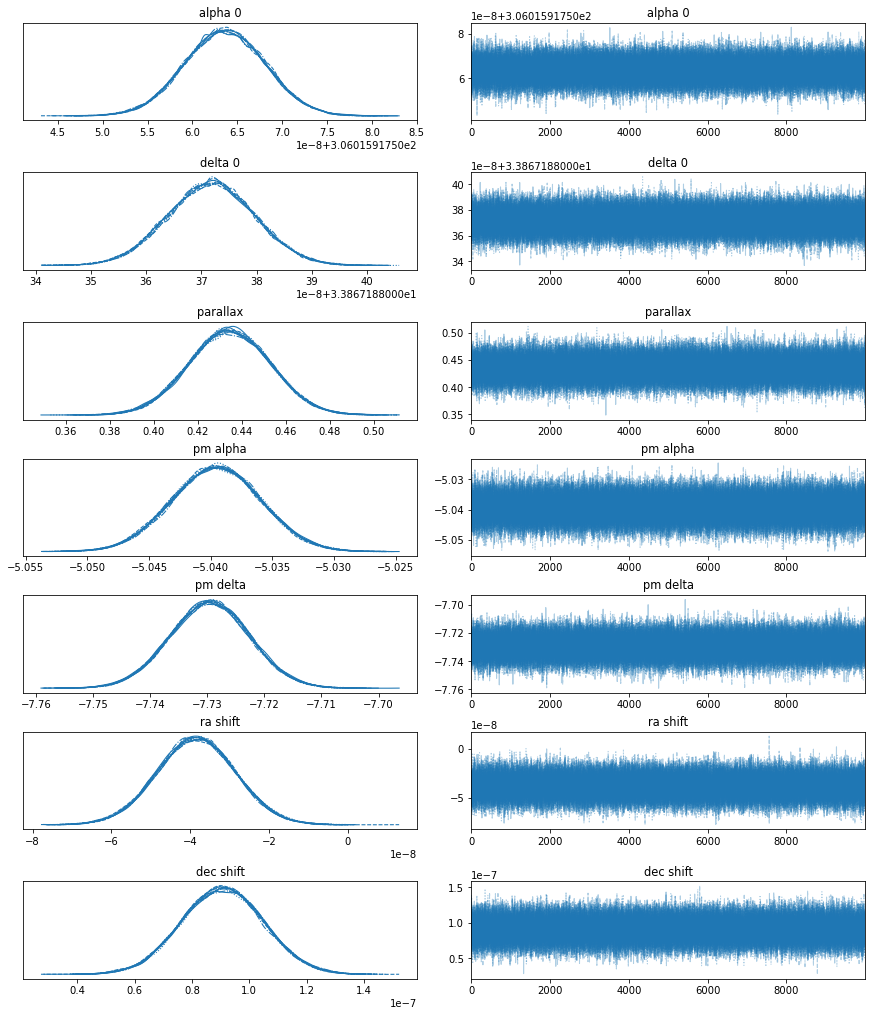

In [11]:
pm.traceplot(V404_trace_2D)

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>],
       [<AxesSubplot:title={'center':'ra shift'}>,
        <AxesSubplot:title={'center':'ra shift'}>],
       [<AxesSubplot:title={'center':'dec shift'}>,
        <AxesSubplot:title={'center':'dec shift'}>]], dtype=object)

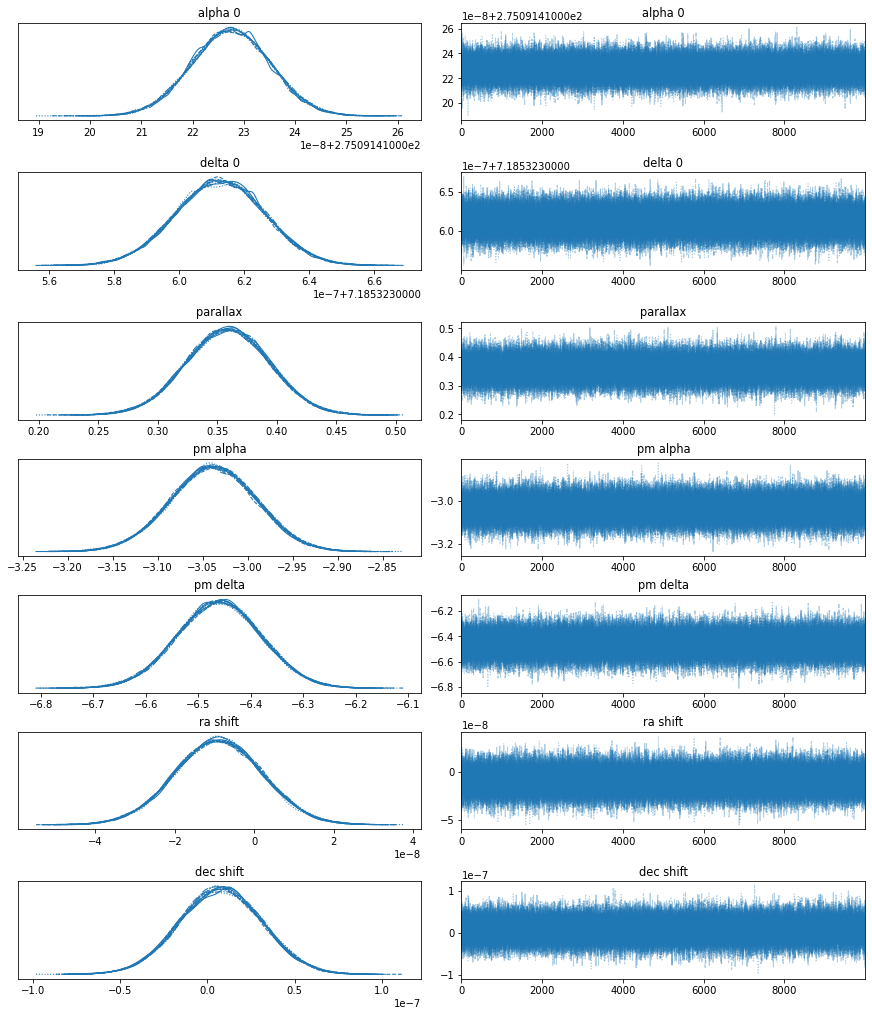

In [12]:
pm.traceplot(J1820_trace_2D)

In [13]:
print("The determined core-shift for V404 offsets are")
print('ra  nu : {} mas'.format(np.median(V404_trace_2D['ra shift'])*3.6e6))
print('ra  sd : {} mas'.format(np.std(V404_trace_2D['ra shift'])*3.6e6))
print('dec nu : {} mas'.format(np.median(V404_trace_2D['dec shift'])*3.6e6))
print('dec sd : {} mas'.format(np.std(V404_trace_2D['dec shift'])*3.6e6))


print("The determined core-shift for J1820 offsets are")
print('ra  nu : {} mas'.format(np.median(J1820_trace_2D['ra shift'])*3.6e6))
print('ra  sd : {} mas'.format(np.std(J1820_trace_2D['ra shift'])*3.6e6))
print('dec nu : {} mas'.format(np.median(J1820_trace_2D['dec shift'])*3.6e6))
print('dec sd : {} mas'.format(np.std(J1820_trace_2D['dec shift'])*3.6e6))

The determined core-shift for V404 offsets are
ra  nu : -0.13840071488857575 mas
ra  sd : 0.035766262474354084 mas
dec nu : 0.32613055256369705 mas
dec sd : 0.05121970494145718 mas
The determined core-shift for J1820 offsets are
ra  nu : -0.03248823510215715 mas
ra  sd : 0.03962463179297164 mas
dec nu : 0.02756730124175988 mas
dec sd : 0.08482104617544589 mas


#### Update alpha and delta based on coreshift

In [14]:
V404_alphaXC_coreshifted = V404_alphaXC + V404_maskXC*np.median(V404_trace_2D['ra shift'])
V404_deltaXC_coreshifted = V404_deltaXC + V404_maskXC*np.median(V404_trace_2D['dec shift'])
## add errors in quadrature
V404_alpha_errXC_coreshifted = np.sqrt(V404_alpha_errXC**2 + np.std(V404_trace_2D['ra shift'])**2)
V404_delta_errXC_coreshifted = np.sqrt(V404_delta_errXC**2 + np.std(V404_trace_2D['dec shift'])**2)



J1820_alpha_coreshifted = J1820_alpha + J1820_mask*np.median(J1820_trace_2D['ra shift'])
J1820_delta_coreshifted = J1820_delta + J1820_mask*np.median(J1820_trace_2D['dec shift'])
## add errors in quadrature
J1820_alpha_err_coreshifted = np.sqrt(J1820_alpha_err**2 + np.std(J1820_trace_2D['ra shift'])**2)
J1820_delta_err_coreshifted = np.sqrt(J1820_delta_err**2 + np.std(J1820_trace_2D['dec shift'])**2)

#### Perform 1D MCMC fitting

In [15]:
V404_theta_perp_t, V404_theta_para_t = jet_coordinates(V404_alphaXC_coreshifted * np.cos(np.radians(V404_deltaXC_coreshifted))\
                                             , V404_deltaXC_coreshifted, V404_jet_angle)
V404_theta_perp_er = np.sqrt((V404_alpha_errXC_coreshifted * np.cos(np.radians(V404_jet_angle)))**2\
                        + (V404_delta_errXC_coreshifted * np.sin(np.radians(V404_jet_angle)))**2)
V404_theta_para_er = np.sqrt((V404_alpha_errXC_coreshifted * np.sin(np.radians(V404_jet_angle)))**2\
                        + (V404_delta_errXC_coreshifted * np.cos(np.radians(V404_jet_angle)))**2)


with pm.Model() as projection_model:
    
    ra_0_guessXC = V404_alphaXC.mean()
    dec_0_guessXC = V404_deltaXC.mean()
    


    alpha_0_prior = pm.Normal('alpha 0',
                              mu=V404_trace_2D.get_values('alpha 0').mean(),
                              sd=V404_trace_2D.get_values('alpha 0').std())
    delta_0_prior = pm.Normal('delta 0',
                              mu=V404_trace_2D.get_values('delta 0').mean(),
                              sd=V404_trace_2D.get_values('delta 0').std())
    
    parallax_prior = pm.Normal('parallax',
                              mu=V404_trace_2D.get_values('parallax').mean(),
                              sd=V404_trace_2D.get_values('parallax').std())
    pm_alpha_prior = pm.Normal('pm alpha', 
                               mu=V404_trace_2D.get_values('pm alpha').mean(),
                               sd=V404_trace_2D.get_values('pm alpha').std())                      # In milliarcsec/yr
    
    pm_delta_prior = pm.Normal('pm delta', 
                               mu=V404_trace_2D.get_values('pm delta').mean(),
                               sd=V404_trace_2D.get_values('pm delta').std())                      # In milliarcsec/yr
    
#     ra_core_shift_prior = pm.Normal('ra shift',
#                                     mu=V404_trace_2D.get_values('ra shift').mean(),
#                                     sd=V404_trace_2D.get_values('ra shift').std()) ## in deg (to prevent chain failing)
#     dec_core_shift_prior = pm.Normal('dec shift', 
#                                      mu=V404_trace_2D.get_values('dec shift').mean(),
#                                      sd=V404_trace_2D.get_values('dec shift').std()) ## in deg
    
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    #####
    
    ## apply core shift to obs
    #V404_alpha_coreshifted = V404_alphaXC + V404_maskXC*ra_core_shift_prior
    #V404_delta_coreshifted = V404_deltaXC + V404_maskXC*dec_core_shift_prior
    
    
    # Expected values for RA and Dec:
    # expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
    #                                          alpha = V404_alpha_coreshifted,
    #                                          delta = V404_delta_coreshifted,
    #                                          alpha_0 = alpha_0_prior,
    #                                          delta_0 = delta_0_prior,
    #                                          pm_alpha = pm_alpha_prior,
    #                                          pm_delta = pm_delta_prior,
    #                                          parallax = parallax_prior,
    #                                          orb_T_0 = orb_T_0_prior,
    #                                          orb_P = orb_P_prior,
    #                                          orb_e = orb_e_prior,
    #                                          orb_i = orb_i_prior,
    #                                          orb_omega = orb_omega_prior,
    #                                          orb_Omega = orb_Omega_prior,
    #                                          orb_a = orb_a_prior,
    #                                          binary_orbit = False)
    
    
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
                                             alpha = V404_alphaXC_coreshifted,
                                             delta = V404_deltaXC_coreshifted,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    
    expected_theta_perp, expected_theta_para = jet_coordinates(expected_ra, expected_dec, V404_jet_angle)
    
    # Observed quantities:  
    fitting_theta_perp = pm.Normal('theta_perp', mu = expected_theta_perp,
                                   sd = V404_theta_perp_er,
                                   observed = V404_theta_perp_t)

    step_method = pm.NUTS()
    V404_trace_1D = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    

    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:103: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 30 seconds.


In [16]:
J1820_theta_perp_t, J1820_theta_para_t = jet_coordinates(J1820_alpha_coreshifted * np.cos(np.radians(J1820_delta_coreshifted))\
                                             , J1820_delta_coreshifted, J1820_jet_angle)
J1820_theta_perp_er = np.sqrt((J1820_alpha_err_coreshifted * np.cos(np.radians(J1820_jet_angle)))**2\
                        + (J1820_delta_err_coreshifted * np.sin(np.radians(J1820_jet_angle)))**2)
J1820_theta_para_er = np.sqrt((J1820_alpha_err_coreshifted * np.sin(np.radians(J1820_jet_angle)))**2\
                        + (J1820_delta_err_coreshifted * np.cos(np.radians(J1820_jet_angle)))**2)


with pm.Model() as projection_model:
    
    ra_0_guessXC = J1820_alpha.mean()
    dec_0_guessXC = J1820_delta.mean()
    


    alpha_0_prior = pm.Normal('alpha 0',
                              mu=J1820_trace_2D.get_values('alpha 0').mean(),
                              sd=J1820_trace_2D.get_values('alpha 0').std())
    delta_0_prior = pm.Normal('delta 0',
                              mu=J1820_trace_2D.get_values('delta 0').mean(),
                              sd=J1820_trace_2D.get_values('delta 0').std())
    
    parallax_prior = pm.Normal('parallax',
                              mu=J1820_trace_2D.get_values('parallax').mean(),
                              sd=J1820_trace_2D.get_values('parallax').std())
    pm_alpha_prior = pm.Normal('pm alpha', 
                               mu=J1820_trace_2D.get_values('pm alpha').mean(),
                               sd=J1820_trace_2D.get_values('pm alpha').std())                      # In milliarcsec/yr
    
    pm_delta_prior = pm.Normal('pm delta', 
                               mu=J1820_trace_2D.get_values('pm delta').mean(),
                               sd=J1820_trace_2D.get_values('pm delta').std())                      # In milliarcsec/yr
    
#     ra_core_shift_prior = pm.Normal('ra shift',
#                                     mu=V404_trace_2D.get_values('ra shift').mean(),
#                                     sd=V404_trace_2D.get_values('ra shift').std()) ## in deg (to prevent chain failing)
#     dec_core_shift_prior = pm.Normal('dec shift', 
#                                      mu=V404_trace_2D.get_values('dec shift').mean(),
#                                      sd=V404_trace_2D.get_values('dec shift').std()) ## in deg
    
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    #####
    
    ## apply core shift to obs
    #V404_alpha_coreshifted = V404_alphaXC + V404_maskXC*ra_core_shift_prior
    #V404_delta_coreshifted = V404_deltaXC + V404_maskXC*dec_core_shift_prior
    
    
    # Expected values for RA and Dec:
    # expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
    #                                          alpha = V404_alpha_coreshifted,
    #                                          delta = V404_delta_coreshifted,
    #                                          alpha_0 = alpha_0_prior,
    #                                          delta_0 = delta_0_prior,
    #                                          pm_alpha = pm_alpha_prior,
    #                                          pm_delta = pm_delta_prior,
    #                                          parallax = parallax_prior,
    #                                          orb_T_0 = orb_T_0_prior,
    #                                          orb_P = orb_P_prior,
    #                                          orb_e = orb_e_prior,
    #                                          orb_i = orb_i_prior,
    #                                          orb_omega = orb_omega_prior,
    #                                          orb_Omega = orb_Omega_prior,
    #                                          orb_a = orb_a_prior,
    #                                          binary_orbit = False)
    
    
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = J1820_time,
                                             alpha = J1820_alpha_coreshifted,
                                             delta = J1820_delta_coreshifted,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    
    expected_theta_perp, expected_theta_para = jet_coordinates(expected_ra, expected_dec, J1820_jet_angle)
    
    # Observed quantities:  
    fitting_theta_perp = pm.Normal('theta_perp', mu = expected_theta_perp,
                                   sd = J1820_theta_perp_er,
                                   observed = J1820_theta_perp_t)

    step_method = pm.NUTS()
    J1820_trace_1D = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    

    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:103: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 28 seconds.


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>]], dtype=object)

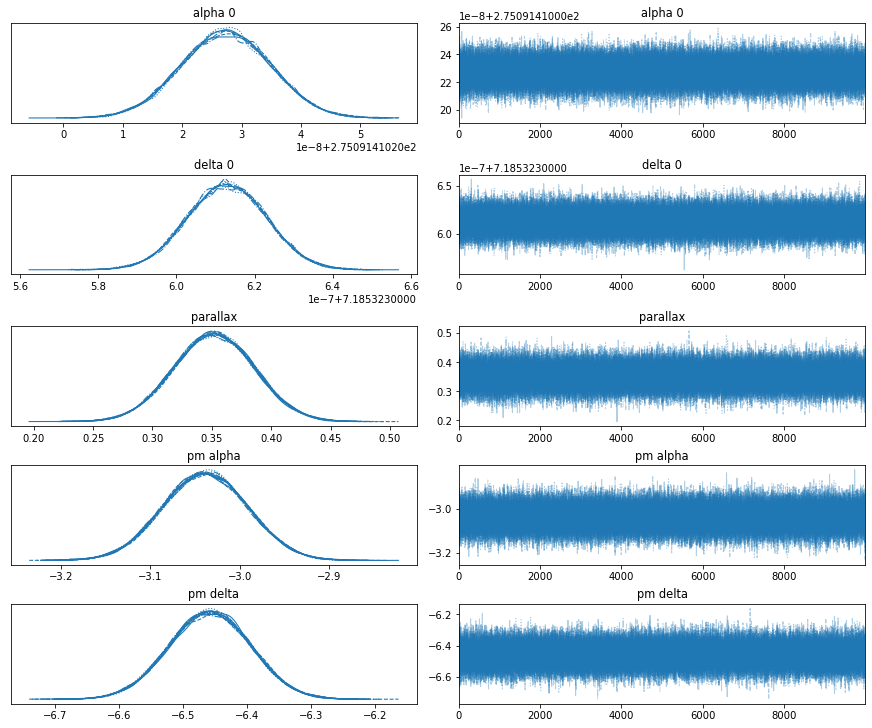

In [17]:
pm.traceplot(J1820_trace_1D)

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>]], dtype=object)

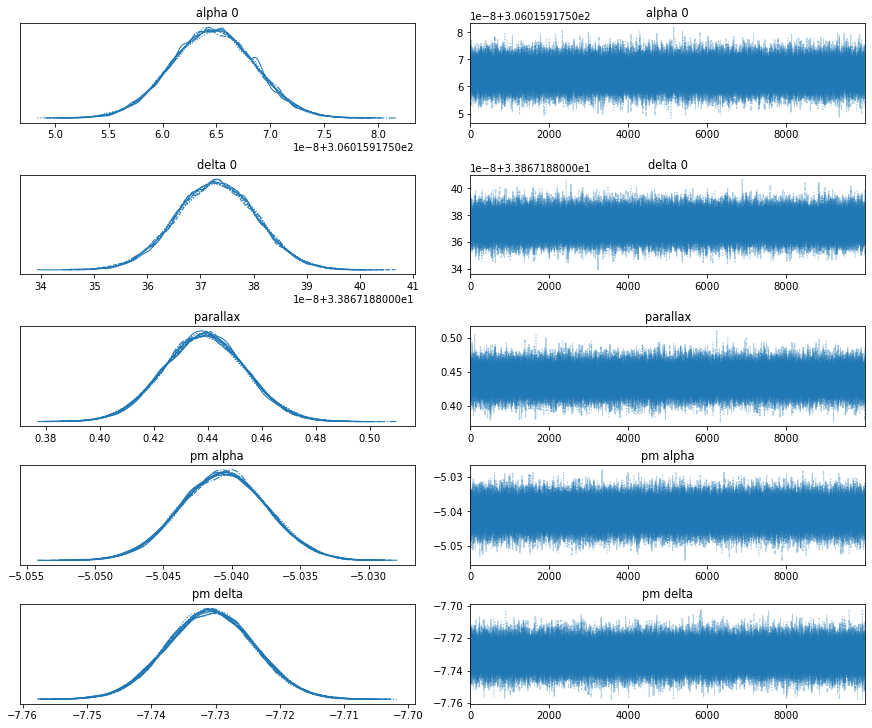

In [18]:
pm.traceplot(V404_trace_1D)

#### Make parallax signal and residuals

100%|██████████| 100/100 [00:01<00:00, 91.21it/s]


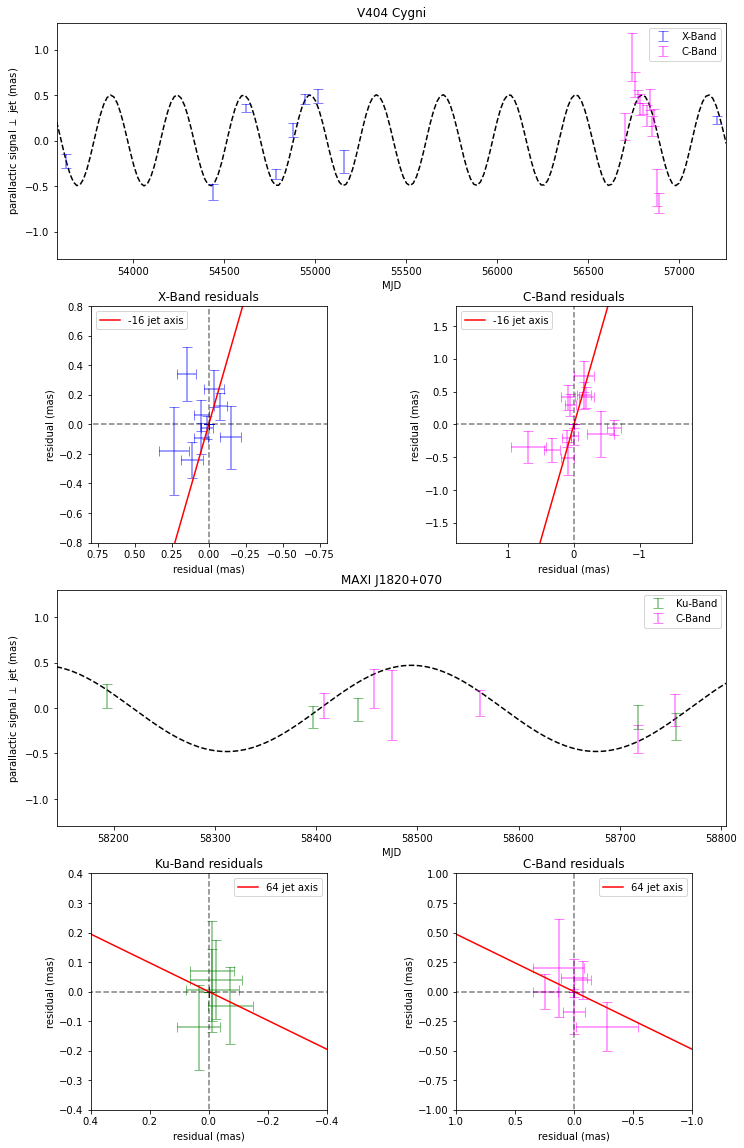

In [137]:
V404_c_band_mask = np.invert(np.copy(V404_maskXC))
V404_ra_residual_trace = []
V404_dec_residual_trace = []
V404_ra_parallax_signal_trace = []
V404_dec_parallax_signal_trace = []
V404_perp_trace = []
V404_para_trace = []

for i in tqdm(range(mc_iterations)):
    
    ## perturb observation
    V404_alpha, V404_delta = perturbObsBasedOnErr(V404_alphaXC_coreshifted, V404_alpha_errXC_coreshifted,\
                                                V404_deltaXC_coreshifted, V404_delta_errXC_coreshifted)
    
    V404_time = np.copy(V404_timeXC)
    
    ## perturb proper motion and parallax
    pm_alpha_deg = mc_trace_sampler(V404_trace_1D['pm alpha']) / 3.6e6 / 365.25    
    pm_delta_deg = mc_trace_sampler(V404_trace_1D['pm delta']) / 3.6e6 / 365.25    
    parallax_deg = mc_trace_sampler(V404_trace_1D['parallax']) / 3.6e6
    alpha_0 = mc_trace_sampler(V404_trace_1D['alpha 0'])
    delta_0 = mc_trace_sampler(V404_trace_1D['delta 0'])
    
    ## compute proper motion and residuals
    frac_alpha, frac_delta = skymotion.frac_parallax(V404_time, V404_alpha, V404_delta)
    ref_t = skymotion.t_0(V404_time)
    fit_ra_proper = alpha_0 * np.cos(np.radians(V404_delta)) + (pm_alpha_deg * (V404_time - ref_t))
    fit_dec_proper = delta_0 + (pm_delta_deg * (V404_time - ref_t))
    fit_ra = fit_ra_proper + frac_alpha * parallax_deg
    fit_dec = fit_dec_proper + frac_delta * parallax_deg
    
    V404_ra_parallax_signal_trace.append(V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra_proper)
    V404_dec_parallax_signal_trace.append(V404_delta - fit_dec_proper)
    V404_ra_residual_trace.append(V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra)
    V404_dec_residual_trace.append(V404_delta - fit_dec)
    
    ra = V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra_proper
    dec = V404_delta - fit_dec_proper
    perp_t, para_t = jet_coordinates(ra, dec, V404_jet_angle)
    V404_perp_trace.append(perp_t)
    V404_para_trace.append(para_t)
    
    
    

time_array = np.linspace(np.min(V404_timeXC)-50, np.max(V404_timeXC)+50, 200)

frac_alpha, frac_delta = skymotion.frac_parallax(time_array, np.mean(V404_trace_1D['alpha 0']), \
                                                 np.mean(V404_trace_1D['delta 0']) )

parallax_deg = np.mean(V404_trace_1D['parallax'])
theta_perp_t, theta_para_t = jet_coordinates(frac_alpha * np.cos(np.radians(frac_delta))*parallax_deg\
                                             , frac_delta, V404_jet_angle)
    
fig = plt.figure(figsize=(6*2,10*2))


plt.subplot(4,1,1)
plt.title('V404 Cygni')
plt.plot(time_array, theta_perp_t, color="black", linestyle="dashed")
plt.xlim(min(time_array), max(time_array))



for x, y, z, label in zip(V404_timeXC, np.mean(V404_perp_trace, axis=0)*3.6e6,np.std(V404_perp_trace, axis=0)*3.6e6, V404_labelXC):
    
    if label[0] == "x":
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='blue', alpha=0.5, label="X-Band")
    else:
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='magenta', alpha=0.5, label="C-Band")

#plt.errorbar(V404_timeXC, np.mean(V404_perp_trace, axis=0)*3.6e6, 
#             yerr=np.std(V404_perp_trace, axis=0)*3.6e6, fmt=" ", capsize=5)

plt.ylim(-1.3, 1.3)
plt.ylabel(r'parallactic signal $\perp$ jet (mas)')
plt.xlabel("MJD")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax1 = fig.add_subplot(423)
plt.errorbar(np.median(V404_ra_residual_trace, axis=0)*3.6e6*V404_c_band_mask, np.median(V404_dec_residual_trace, axis=0)*3.6e6*V404_c_band_mask,\
             xerr=np.std(V404_ra_residual_trace, axis=0)*3.6e6*V404_c_band_mask, yerr=np.std(V404_dec_residual_trace, axis=0)*3.6e6*V404_c_band_mask,\
             fmt=' ', capsize=5,color="blue", alpha=0.5)


x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(16 + 90))
plt.plot(x_array, y_array, color="red", label="-16 jet axis")
plt.title("X-Band residuals")
plt.xlabel("residual (mas)")
plt.ylabel("residual (mas)")
plt.xlim(0.8, -0.8)
plt.ylim(-0.8, 0.8)
plt.legend()
plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)



ax2 = fig.add_subplot(424)
plt.errorbar(np.median(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, np.median(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
             xerr=np.std(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, yerr=np.std(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
             fmt=' ', capsize=5,color="magenta", alpha=0.5)


x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(16 + 90))
plt.plot(x_array, y_array, color="red", label="-16 jet axis")
plt.title("C-Band residuals")
plt.xlabel("residual (mas)")
plt.ylabel("residual (mas)")
plt.xlim(1.8, -1.8)
plt.ylim(-1.8, 1.8)
plt.legend()
plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)






################################################### J1820 stuff below
J1820_c_band_mask = np.invert(np.copy(J1820_mask))
J1820_ra_residual_trace = []
J1820_dec_residual_trace = []
J1820_ra_parallax_signal_trace = []
J1820_dec_parallax_signal_trace = []
J1820_perp_trace = []
J1820_para_trace = []

for i in tqdm(range(mc_iterations)):
    
    ## perturb observation
    J1820_alpha, J1820_delta = perturbObsBasedOnErr(J1820_alpha_coreshifted, J1820_alpha_err_coreshifted,\
                                                J1820_delta_coreshifted, J1820_delta_err_coreshifted)
    
    J1820_time = np.copy(J1820_time)
    
    ## perturb proper motion and parallax
    pm_alpha_deg = mc_trace_sampler(J1820_trace_1D['pm alpha']) / 3.6e6 / 365.25    
    pm_delta_deg = mc_trace_sampler(J1820_trace_1D['pm delta']) / 3.6e6 / 365.25    
    parallax_deg = mc_trace_sampler(J1820_trace_1D['parallax']) / 3.6e6
    alpha_0 = mc_trace_sampler(J1820_trace_1D['alpha 0'])
    delta_0 = mc_trace_sampler(J1820_trace_1D['delta 0'])
    
    ## compute proper motion and residuals
    frac_alpha, frac_delta = skymotion.frac_parallax(J1820_time, J1820_alpha, J1820_delta)
    ref_t = skymotion.t_0(J1820_time)
    fit_ra_proper = alpha_0 * np.cos(np.radians(J1820_delta)) + (pm_alpha_deg * (J1820_time - ref_t))
    fit_dec_proper = delta_0 + (pm_delta_deg * (J1820_time - ref_t))
    fit_ra = fit_ra_proper + frac_alpha * parallax_deg
    fit_dec = fit_dec_proper + frac_delta * parallax_deg
    
    J1820_ra_parallax_signal_trace.append(J1820_alpha* np.cos(np.radians(J1820_delta)) - fit_ra_proper)
    J1820_dec_parallax_signal_trace.append(J1820_delta - fit_dec_proper)
    J1820_ra_residual_trace.append(J1820_alpha* np.cos(np.radians(J1820_delta)) - fit_ra)
    J1820_dec_residual_trace.append(J1820_delta - fit_dec)
    
    ra = J1820_alpha* np.cos(np.radians(J1820_delta)) - fit_ra_proper
    dec = J1820_delta - fit_dec_proper
    perp_t, para_t = jet_coordinates(ra, dec, J1820_jet_angle)
    J1820_perp_trace.append(perp_t)
    J1820_para_trace.append(para_t)
    
    
    

time_array = np.linspace(np.min(J1820_time)-50, np.max(J1820_time)+50, 200)

frac_alpha, frac_delta = skymotion.frac_parallax(time_array, np.mean(J1820_trace_1D['alpha 0']), \
                                                 np.mean(J1820_trace_1D['delta 0']) )

parallax_deg = np.mean(J1820_trace_1D['parallax'])
theta_perp_t, theta_para_t = jet_coordinates(frac_alpha * np.cos(np.radians(frac_delta))*parallax_deg\
                                             , frac_delta, J1820_jet_angle)
    

plt.subplot(4,1,3)

plt.plot(time_array, theta_perp_t, color="black", linestyle="dashed")
plt.xlim(min(time_array), max(time_array))



for x, y, z, label in zip(J1820_time, np.mean(J1820_perp_trace, axis=0)*3.6e6,np.std(J1820_perp_trace, axis=0)*3.6e6, J1820_band['Band']):
    
    if label == 5:
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='magenta', alpha=0.5, label="C-Band")
    else:
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='green', alpha=0.5, label="Ku-Band")

#plt.errorbar(V404_timeXC, np.mean(V404_perp_trace, axis=0)*3.6e6, 
#             yerr=np.std(V404_perp_trace, axis=0)*3.6e6, fmt=" ", capsize=5)

plt.ylim(-1.3, 1.3)
plt.ylabel(r'parallactic signal $\perp$ jet (mas)')
plt.xlabel("MJD")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('MAXI J1820+070')


ax3 = fig.add_subplot(427)
plt.errorbar(np.median(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_c_band_mask, np.median(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_c_band_mask,\
             xerr=np.std(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_c_band_mask, yerr=np.std(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_c_band_mask,\
             fmt=' ', capsize=5,color="green", alpha=0.5)


x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(J1820_jet_angle + 90))
plt.plot(x_array, y_array, color="red", label="64 jet axis")
plt.title("Ku-Band residuals")
plt.xlabel("residual (mas)")
plt.ylabel("residual (mas)")
plt.xlim(0.4, -0.4)
plt.ylim(-0.4, 0.4)
plt.legend()
plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)


ax4 = fig.add_subplot(428)
plt.errorbar(np.median(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_mask, np.median(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_mask,\
             xerr=np.std(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_mask, yerr=np.std(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_mask,\
             fmt=' ', capsize=5,color="magenta", alpha=0.5)


x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(J1820_jet_angle + 90))
plt.plot(x_array, y_array, color="red", label="64 jet axis")
plt.title("C-Band residuals")
plt.xlabel("residual (mas)")
plt.ylabel("residual (mas)")
plt.xlim(1, -1)
plt.ylim(-1, 1)
plt.legend()
plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)

ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')


plt.savefig('astrometry.png')

#### load check source data for V404 C-band observations

In [62]:
#load check source data
checkSourceC = Table.read("./c-bandJ2023-3153_globalfitV3.txt", format='ascii',names=['RA', 'RA_err', 'DEC', 'DEC_err', "label"])

## convert values to prefered data types
cs_alpha = SkyCoord(checkSourceC['RA'], checkSourceC['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
cs_delta = SkyCoord(checkSourceC['RA'], checkSourceC['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree
cs_alpha_err = checkSourceC['RA_err']/3600.0*15
cs_delta_err = checkSourceC['DEC_err']/3600.0

cs_mean_alpha = np.median(cs_alpha)
cs_mean_delta = np.median(cs_delta)

In [67]:
print(len(cs_alpha))

12


In [94]:
V404_Cband_ra_res_nu = []
V404_Cband_ra_res_std = []
V404_Cband_dec_res_nu = []
V404_Cband_dec_res_std = []

for ra_nu, ra_std, dec_nu, dec_std, mask in zip(np.median(V404_ra_residual_trace, axis=0)*3.6e6,
                                                np.std(V404_ra_residual_trace, axis=0)*3.6e6,
                                                np.median(V404_dec_residual_trace, axis=0)*3.6e6,
                                                np.std(V404_dec_residual_trace, axis=0)*3.6e6,
                                                V404_maskXC):
    if mask:
        V404_Cband_ra_res_nu.append(ra_nu)
        V404_Cband_ra_res_std.append(ra_std)
        V404_Cband_dec_res_nu.append(dec_nu)
        V404_Cband_dec_res_std.append(dec_std)



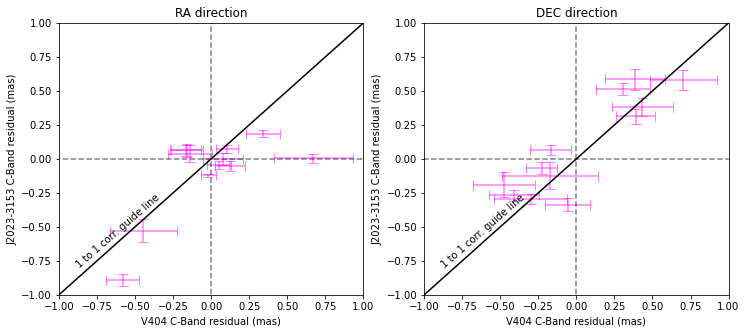

In [138]:
deg2mas = 3.6e6

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("RA direction")
plt.xlabel("V404 C-Band residual (mas)")
plt.ylabel("J2023-3153 C-Band residual (mas)")
plt.xlim(-1, 1)
plt.ylim(-1, 1)

#plt.errorbar(V404_Cband_ra_res_nu, (cs_alpha - cs_mean_alpha)*deg2mas*np.cos(np.radians(cs_delta)), \
#             xerr=V404_Cband_ra_res_std, yerr=cs_alpha_err*deg2mas*np.cos(np.radians(cs_delta)),\
#             fmt=' ', capsize=5, color='magenta', alpha=0.5)


plt.errorbar(V404_Cband_ra_res_nu, (cs_alpha - cs_mean_alpha)*deg2mas, \
             xerr=V404_Cband_ra_res_std, yerr=cs_alpha_err*deg2mas,\
             fmt=' ', capsize=5, color='magenta', alpha=0.5)


plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(-45 + 90))
plt.plot(x_array, y_array, color="black", label="1 to 1 corr. (guide only)")
plt.text(-0.8-0.1, -0.8, "1 to 1 corr. guide line", rotation=41)




plt.subplot(122)
plt.title("DEC direction")
plt.xlabel("V404 C-Band residual (mas)")
plt.ylabel("J2023-3153 C-Band residual (mas)")
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.errorbar(V404_Cband_dec_res_nu, (cs_delta - cs_mean_delta)*deg2mas , \
             xerr=V404_Cband_dec_res_std, yerr=cs_delta_err*deg2mas,\
             fmt=' ', capsize=5, color='magenta', alpha=0.5)
plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(-45 + 90))
plt.plot(x_array, y_array, color="black", label="1 to 1 corr. (guide only)")
plt.text(-0.8-0.1, -0.8, "1 to 1 corr. guide line", rotation=41)

plt.savefig('V404CBandResiduals.png')

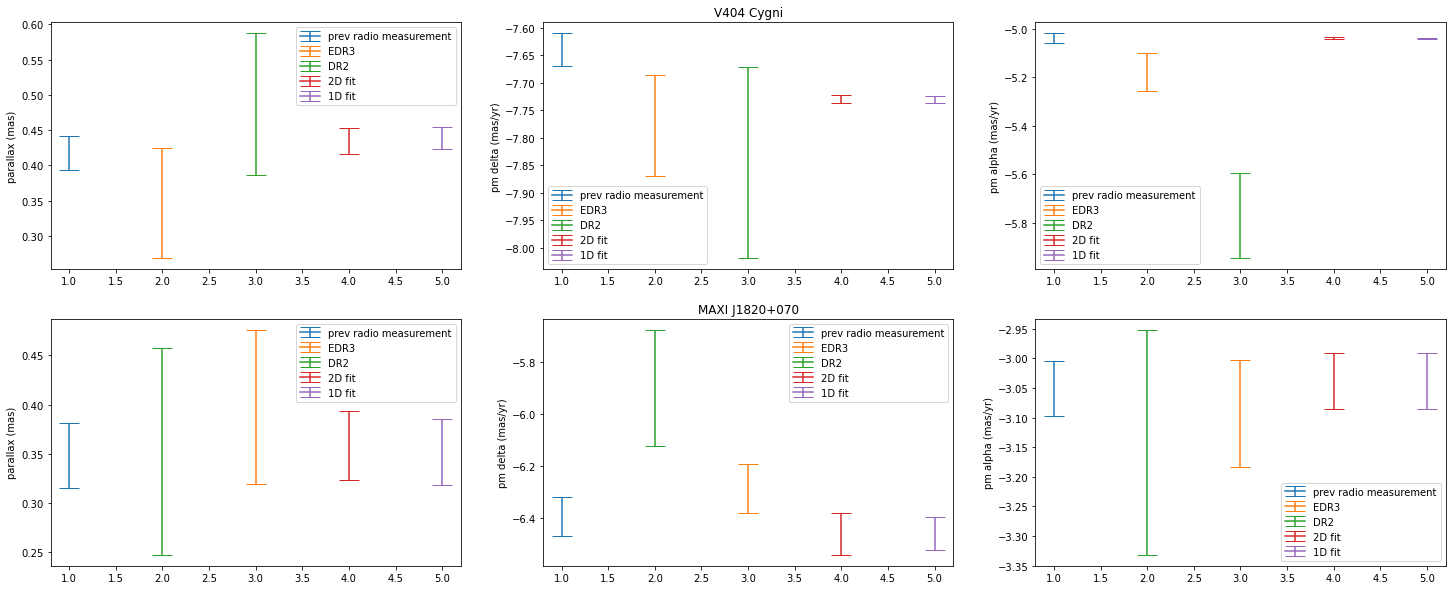

In [139]:
plt.figure(figsize=(25,10))


plt.subplot(231)
plt.errorbar(1, 0.418, yerr=0.024, label="prev radio measurement", capsize=10)
plt.errorbar(2, 0.3470492577849456, yerr=0.07828958332538605, label="EDR3", capsize=10)
plt.errorbar(3, 0.4866918212349863	, yerr=0.10024211093489861, label="DR2", capsize=10)
plt.errorbar(4, np.mean(V404_trace_2D["parallax"]), yerr=np.std(V404_trace_2D["parallax"]), capsize=10, label="2D fit")
plt.errorbar(5, np.mean(V404_trace_1D["parallax"]), yerr=np.std(V404_trace_1D["parallax"]), capsize=10, label="1D fit")

plt.legend()
plt.ylabel("parallax (mas)")

plt.subplot(232)
plt.title('V404 Cygni')
plt.errorbar(1, -7.64, yerr=0.03, label="prev radio measurement", capsize=10)
plt.errorbar(2, -7.777607674200884, yerr= 0.09215836226940155, label="EDR3", capsize=10)
plt.errorbar(3, -7.845423153853458, yerr=0.17347357178314202, label="DR2", capsize=10)
plt.errorbar(4, np.mean(V404_trace_2D["pm delta"]), yerr=np.std(V404_trace_2D["pm delta"]), capsize=10, label="2D fit")
plt.errorbar(5, np.mean(V404_trace_1D["pm delta"]), yerr=np.std(V404_trace_1D["pm delta"]), capsize=10, label="1D fit")
plt.legend()
plt.ylabel("pm delta (mas/yr)")

plt.subplot(233)
plt.errorbar(1, -5.04, yerr=0.02, label="prev radio measurement", capsize=10)
plt.errorbar(2, -5.177496222444664, yerr=0.07850257307291031	, label="EDR3", capsize=10)
plt.errorbar(3, -5.769449220187081, yerr=0.17464374804297733, label="DR2", capsize=10)
plt.errorbar(4, np.mean(V404_trace_2D["pm alpha"]), yerr=np.std(V404_trace_2D["pm alpha"]), capsize=10, label="2D fit")
plt.errorbar(5, np.mean(V404_trace_1D["pm alpha"]), yerr=np.std(V404_trace_1D["pm alpha"]), capsize=10, label="1D fit")
plt.legend()
plt.ylabel("pm alpha (mas/yr)")
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'




plt.subplot(234)
plt.errorbar(1, 0.348, yerr=0.033, label="prev radio measurement", capsize=10)
plt.errorbar(3, 0.3978309267225294, yerr=0.07798400521278381, label="EDR3", capsize=10)
plt.errorbar(2, 0.35266034867208135, yerr=0.10491223252460802, label="DR2", capsize=10)
plt.errorbar(4, np.mean(J1820_trace_2D["parallax"]), yerr=np.std(J1820_trace_2D["parallax"]), capsize=10, label="2D fit")
plt.errorbar(5, np.mean(J1820_trace_1D["parallax"]), yerr=np.std(J1820_trace_1D["parallax"]), capsize=10, label="1D fit")
plt.legend()
plt.ylabel("parallax (mas)")


plt.subplot(235)
plt.title('MAXI J1820+070')
plt.errorbar(1, -6.394, yerr=0.075, label="prev radio measurement", capsize=10)
plt.errorbar(3, -6.285706339181691, yerr=0.0942222997546196, capsize=10, label="EDR3")
plt.errorbar(2, -5.899478497174061, yerr=0.22191783238312623, capsize=10, label="DR2")

plt.errorbar(4, np.mean(J1820_trace_2D["pm delta"]), yerr=np.std(J1820_trace_2D["pm delta"]), capsize=10, label="2D fit")
plt.errorbar(5, np.mean(J1820_trace_1D["pm delta"]), yerr=np.std(J1820_trace_1D["pm delta"]), capsize=10, label="1D fit")
plt.legend()
plt.ylabel("pm delta (mas/yr)")


plt.subplot(236)
plt.errorbar(1, -3.051, yerr=0.046, label="prev radio measurement", capsize=10)
plt.errorbar(3, -3.092926397092064, yerr=0.09064880013465881, label="EDR3", capsize=10)
plt.errorbar(2, -3.141733813942684, yerr=0.18948128219427948, label="DR2", capsize=10)

plt.errorbar(4, np.mean(J1820_trace_2D["pm alpha"]), yerr=np.std(J1820_trace_2D["pm alpha"]), capsize=10, label="2D fit")
plt.errorbar(5, np.mean(J1820_trace_1D["pm alpha"]), yerr=np.std(J1820_trace_1D["pm alpha"]), capsize=10, label="1D fit")
plt.legend()
plt.ylabel("pm alpha (mas/yr)")
plt.savefig('results.png')